# Introduction

This is an interactive tutorial for training CTC-based speech recognition using:
1. [YesNo](http://www.openslr.org/1/) toy data.
2. Built-in CTCLoss in PyTorch
3. Built-in acoustic feature in TorchAudio

## Requirements

* torch (>= 1.4.0)
* torchaudio (>= 0.4.0)

I didn't use \*conda platforms, installed these packages using pip.

# Preparing data

TorchAudio has a built-in yesno dataset, so we just use that, and see what the acoustic features look like.
First, download and untar the package using TorchAudio.

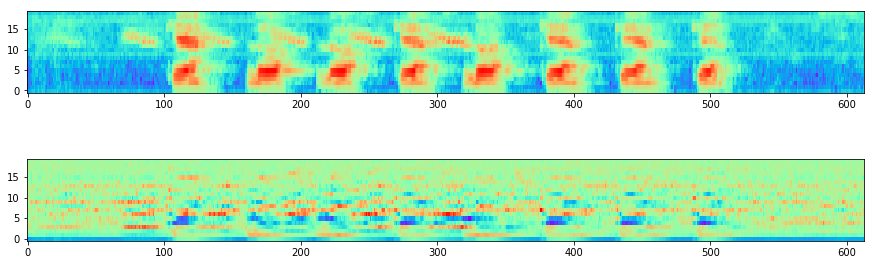

In [1]:
import torchaudio
yesno_raw = torchaudio.datasets.YESNO('.', download=True)

# Let's see what the spectrogram looks like
fbank = torchaudio.compliance.kaldi.fbank(yesno_raw[0][0], sample_frequency=yesno_raw[0][1], num_mel_bins=20)
mfcc = torchaudio.compliance.kaldi.mfcc(yesno_raw[0][0], sample_frequency=yesno_raw[0][1], num_mel_bins=20, num_ceps=20)
%matplotlib inline
import matplotlib.pyplot as plot
plot.rcParams["figure.figsize"] = (15,5)
plot.subplot(211)
plot.imshow(fbank.transpose(0,1), cmap='rainbow', origin='lowest', aspect=3)
plot.subplot(212)
plot.imshow(mfcc.transpose(0,1), cmap='rainbow', origin='lowest', aspect=3)

Since YesNo audio is sampled at 8kHz, 20-dim acoustic feature should be enough. Fbank is visually more representative, but MFCCs are de facto standard acoustic feature for speech recognition, so let's use that.

## Define dataset for training

The raw YesNo dataset defined in TorchAudio is simply a collection of waveform and transcription. In order to feed the data to a CTC trainer, there are some preprocessings to do, including: 
* label formatting: in raw label 0 means 'NO', 1 means 'YES', map to {\<blank>:0, \<space>:1, 'E':2, 'N':3, 'O':4, 'S':5, 'Y':6}
  So the token size is 7.
* splice neighbour frames and subsample by factor of 3, referred to [this repo](https://github.com/ZhengkunTian/rnn-transducer)
  Now the feature dimension is 140.
* padding both acoustic feature and targets to longest utterance

In [2]:
import torchaudio
import numpy as np
from torch.utils.data import Dataset
class YesNoDataset(Dataset):
    def __init__(self, root):
        self.raw = torchaudio.datasets.YESNO(root, download=False)
        self.target_map = [[3, 4], [6, 2, 5]]
        self.left_context = 3
        self.right_context = 3
        self.subsample_factor = 3
        self.max_input_length = 400
        self.max_target_length = 40

    def __getitem__(self, index):
        wave_form, rate, label = self.raw[index]
        fbank = torchaudio.compliance.kaldi.mfcc(wave_form, sample_frequency=rate, num_mel_bins=20, num_ceps=20)
        features = self.splice_and_subsample(fbank)
        targets = self.map_targets(label)

        inputs_length = np.array(features.shape[0]).astype(np.int64)
        targets_length = np.array(targets.shape[0]).astype(np.int64)

        features = self.pad(features, self.max_input_length).astype(np.float32)
        targets = self.pad(targets, self.max_target_length).astype(np.int64).reshape(-1)

        return features, inputs_length, targets, targets_length

    def __len__(self):
        return len(self.raw)

    def splice_and_subsample(self, features):
        time_steps, features_dim = features.shape
        spliced_features = np.zeros(
            shape=[time_steps, features_dim *
                   (1 + self.left_context + self.right_context)],
            dtype=np.float32)
        # middle part is just the uttarnce
        spliced_features[:, self.left_context * features_dim:
                          (self.left_context + 1) * features_dim] = features

        for i in range(self.left_context):
            # add left context
            spliced_features[i + 1:time_steps,
                              (self.left_context - i - 1) * features_dim:
                              (self.left_context - i) * features_dim] = features[0:time_steps - i - 1, :]

        for i in range(self.right_context):
            # add right context
            spliced_features[0:time_steps - i - 1,
                              (self.right_context + i + 1) * features_dim:
                              (self.right_context + i + 2) * features_dim] = features[i + 1:time_steps, :]

        temp_mat = [spliced_features[i] for i in range(0, spliced_features.shape[0], self.subsample_factor)]
        subsampled_features = np.row_stack(temp_mat)
        return subsampled_features
    
    def map_targets(self, label):
        targets = []
        for idx, word in enumerate(label):
            targets.extend(self.target_map[word])
            if (idx < len(label) - 1) : targets.append(1) 
        return np.array(targets)
    
    def pad(self, inputs, max_length):
        dim = len(inputs.shape)
        if dim == 1:
            # padding targets
            pad_zeros_mat = np.zeros([1, max_length - inputs.shape[0]], dtype=np.int32)
            padded_inputs = np.column_stack([inputs.reshape(1, -1), pad_zeros_mat])
        elif dim == 2:
            # padding inputs
            feature_dim = inputs.shape[1]
            pad_zeros_mat = np.zeros([max_length - inputs.shape[0], feature_dim])
            padded_inputs = np.row_stack([inputs, pad_zeros_mat])
        return padded_inputs

In [3]:
yesno_data = YesNoDataset('.')

## Define data loader

Before training, split data into train and test. Ramdonly select 50 utterances as train and others as test.

In [4]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
indices = list(range(len(yesno_data)))
np.random.shuffle(indices)
train_indices, test_indices = indices[:50], indices[50:]
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
training_data = DataLoader(yesno_data, batch_size=4, shuffle=False, num_workers=2, sampler=train_sampler)
test_data = DataLoader(yesno_data, batch_size=1, shuffle=False, num_workers=2, sampler=test_sampler)

# Define model

Now that we have processed data, let's define a model and select an optimizer for training.

The model used in CTC training is no difference to NN-HMM hybrid systems, except that the output is charactors instead of senones.
Actually, you can use context-dependent phones as CTC output token, but here it is not necessary.
We will use simple RNN since it is easy to train and is enough for this task.

According to official [document](https://pytorch.org/docs/stable/nn.html#ctcloss), the input to CTCLoss should be:
1. Padded batch of logarithm softmax, with temporal index first.
2. Padded batch of targets, with batch index first.

Also, let's define a very simple recognizer, which outputs the token with highest probability at each time step, removes blank and merge repeated tokens. Since we do not have words with repeated letters like `Hello`, such a simple recognizer is enough.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class CTC(nn.Module):
    def __init__(self):
        super(CTC, self).__init__()
        self.rnn = nn.RNN(input_size=140, hidden_size=100, num_layers=1, bidirectional=True, batch_first=True)
        self.output = nn.Linear(200, 7, bias=True)
        self.loss_fn = nn.CTCLoss()

    def forward(self, inputs, inputs_length, targets, targets_length):
        # make inputs and parameters contiguous
        sorted_seq_lengths, indices = torch.sort(inputs_length, descending=True)
        inputs = inputs[indices]
        inputs = nn.utils.rnn.pack_padded_sequence(inputs, sorted_seq_lengths, batch_first=True)
        self.rnn.flatten_parameters()
        outputs, _ = self.rnn(inputs)
        _, desorted_indices = torch.sort(indices, descending=False)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        outputs = outputs[desorted_indices]
        logits = self.output(outputs).log_softmax(2)
        
        # calculate CTC loss, switch logitc from (N, T, C) to (T, N, C)
        logits = logits.transpose(0, 1).contiguous()
        loss = self.loss_fn(logits, targets.int(), inputs_length.int(), targets_length.int())
        return loss

    def recognize(self, inputs):
        dic = ['', ' ', 'E', 'N', 'O', 'S', 'Y']
        if (len(inputs.shape) == 2):
            inputs = torch.unsqueeze(inputs, 0)
        outputs, _ = self.rnn(inputs)
        logits = self.output(outputs).softmax(2).detach()
        rdigit = []
        for logit in logits[0]:
            pred = int(torch.argmax(logit, dim=0).item())
            if pred != 0:
                if len(rdigit) > 0 and pred == rdigit[-1]:
                    continue
                rdigit.append(pred)
        result = ''.join([dic[x] for x in rdigit])
        return result, logits

torch.cuda.manual_seed(20200513)
model = CTC()
model = model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.006, momentum=0.9, weight_decay=0)

# Define a training epoch

Now that everything is prepared, we just need to define a training loop that continuously consumes training data. We use the CTC loss to track the training procedure.

In [6]:
def train(epoch, model, training_data, optimizer):
    model.train()
    total_loss = 0  # track loss
    for step, (inputs, inputs_length, targets, targets_length) in enumerate(training_data):
        # copy data to gpu device
        inputs, inputs_length = inputs.cuda(), inputs_length.cuda()
        targets, targets_length = targets.cuda(), targets_length.cuda()
        max_inputs_length = inputs_length.max().item()
        max_targets_length = targets_length.max().item()
        inputs = inputs[:, :max_inputs_length, :]
        targets = targets[:, :max_targets_length]

        # real thing
        optimizer.zero_grad()
        loss = model(inputs, inputs_length, targets, targets_length)
        loss = torch.mean(loss)
        loss.backward()
        total_loss += loss.item()
        nn.utils.clip_grad_norm_(model.parameters(), 200)
        optimizer.step()
        avg_loss = total_loss / (step + 1)
    print('epoch {0}: avg_loss {1}'.format(epoch, avg_loss))

Lets trigger the training and simply run for 100 epochs to see what happens.

In [7]:
for epoch in range(1, 100):
    train(epoch, model, training_data, optimizer)

epoch 1: avg_loss 3.532259152485774
epoch 2: avg_loss 0.844787414257343
epoch 3: avg_loss 0.2716597295724429
epoch 4: avg_loss 0.1593969063116954
epoch 5: avg_loss 0.12293208333162162
epoch 6: avg_loss 0.09932468544978362
epoch 7: avg_loss 0.09364846348762512
epoch 8: avg_loss 0.07930081681563304
epoch 9: avg_loss 0.07216782352099052
epoch 10: avg_loss 0.06267090972799522
epoch 11: avg_loss 0.05909190642145964
epoch 12: avg_loss 0.05445988189715605
epoch 13: avg_loss 0.05002393086369221
epoch 14: avg_loss 0.0466679697139905
epoch 15: avg_loss 0.04347210807295946
epoch 16: avg_loss 0.04145779804541515
epoch 17: avg_loss 0.037984248680564076
epoch 18: avg_loss 0.035188606152167685
epoch 19: avg_loss 0.033914288792472616
epoch 20: avg_loss 0.03197969668186628
epoch 21: avg_loss 0.03023181841350519
epoch 22: avg_loss 0.02920288578248941
epoch 23: avg_loss 0.02850689495412203
epoch 24: avg_loss 0.026438264892651483
epoch 25: avg_loss 0.025728117531308763
epoch 26: avg_loss 0.024324207566678

# Recognize

The loss looks not bad! Now, let's take one test data, and feed it to the simple recognizer to see the output.

In [11]:
test = next(iter(test_data))
model.eval()
result, logits = model.recognize(test[0].cuda())
print(result)

YES YES YES NO NO NO NO YES 


Compare the output to the label, see it is 100% correct!

In [12]:
dic = ['', ' ', 'E', 'N', 'O', 'S', 'Y']
label = ''.join([dic[x] for x in test[2][0]])
print(label)

YES YES YES NO NO NO NO YES


## Probability

Remember we also output the probability of the test sequence? Let draw the probability sequence of each token and see how it aligns with the raw waveform

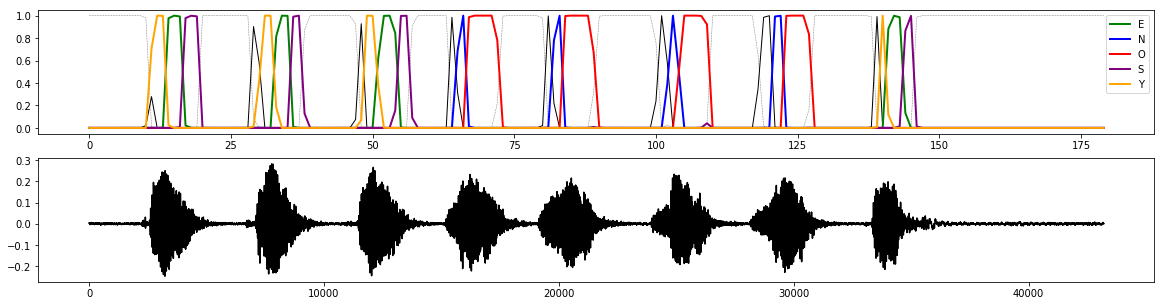

In [13]:
import matplotlib.pyplot as plot
probs = logits[0].transpose(0, 1).cpu().numpy()
show_start = 20
show_end = 200
plot.rcParams["figure.figsize"] = (20,5)
plot.subplot(211)
plot.plot(probs[0][show_start:show_end], '--', color='gray', linewidth=0.5)
plot.plot(probs[1][show_start:show_end], color='black', linewidth=1)
plot.plot(probs[2][show_start:show_end], color='green', linewidth=2, label='E')
plot.plot(probs[3][show_start:show_end], color='blue', linewidth=2, label='N')
plot.plot(probs[4][show_start:show_end], color='red', linewidth=2, label='O')
plot.plot(probs[5][show_start:show_end], color='purple', linewidth=2, label='S')
plot.plot(probs[6][show_start:show_end], color='orange', linewidth=2, label='Y')
plot.legend()
plot.subplot(212)
yesno_raw = torchaudio.datasets.YESNO('.', download=False)
for raw in yesno_raw:
    if raw[2] == [1, 1, 1, 0, 0, 0, 0, 1]:
        wave = raw[0]
        break
plot.plot(wave[0][(show_start*30*8):(show_end*30*8)], color='black')

# Conclusion

Voila! This is 101 interactive end-to-end speech recognition using CTC. I need to confess that, I ran for several times to get this result. There are several simple improvements to make it stable, inluding but not limited to:
1. normalize the input feature
2. use a learning rate scheduler
3. switch to other optimizers, so you don't need this many epochs

It's your turn to explore more data and more complex models!